# Inverse scattering for circular billiard

## Importação das bibliotecas

In [1]:
import numpy as np
import scipy
import scipy.special as sc
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import utils.Utils as utils
import model.GeneralizedMLP as gMLP

## Lendo os dados

In [2]:
df = pd.read_csv('./data/dados.csv')

In [3]:
df

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k587,l_k588,l_k589,l_k590,l_k591,l_k592,l_k593,l_k594,l_k595,l_k596
0,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.100000,0.155397,...,0.001165,0.001162,0.001160,0.001158,0.001156,0.001154,0.001151,0.001149,0.001147,0.001145
1,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.110053,0.184685,...,0.001384,0.001382,0.001379,0.001376,0.001374,0.001371,0.001368,0.001366,0.001363,0.001360
2,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.120106,0.215951,...,0.001616,0.001613,0.001610,0.001607,0.001603,0.001600,0.001597,0.001594,0.001591,0.001587
3,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.130159,0.249095,...,0.001859,0.001855,0.001851,0.001847,0.001843,0.001839,0.001836,0.001832,0.001828,0.001824
4,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,0.1,0.140212,0.284026,...,0.002109,0.002105,0.002100,0.002096,0.002091,0.002087,0.002082,0.002078,0.002073,0.002069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55095,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.959788,34.509730,...,9.570126,9.597571,9.622035,9.642763,9.658887,9.669430,9.673316,9.669396,9.656485,9.633432
55096,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.969841,34.602123,...,9.705567,9.723303,9.735533,9.741150,9.738963,9.727735,9.706246,9.673381,9.628239,9.570257
55097,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.979894,34.694353,...,9.808430,9.808259,9.799045,9.779501,9.748425,9.704819,9.648019,9.577836,9.494682,9.399662
55098,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,3.0,1.989947,34.786420,...,9.853002,9.824148,9.782554,9.727437,9.658485,9.576006,9.481020,9.375310,9.261361,9.142220


## Plot da scattering cross length para gamma, R = 2.0

In [4]:
df_R_2 = df[df['R'] == 2.0]

In [5]:
row_gamma_R_2 = df_R_2[(df_R_2['gamma'] > 1.97) & (df_R_2['gamma'] < 2.03)]

In [6]:
row_gamma_R_2

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k587,l_k588,l_k589,l_k590,l_k591,l_k592,l_k593,l_k594,l_k595,l_k596
35719,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.976471,2.0,34.160977,...,6.956875,6.919069,6.885087,6.855019,6.828886,6.806644,6.788192,6.773382,6.762030,6.753920
35909,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.986505,2.0,34.171447,...,6.987403,6.948690,6.913837,6.882948,6.856052,6.833113,6.814034,6.798671,6.786840,6.778324
36099,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.996540,2.0,34.181816,...,7.017881,6.978250,6.942513,6.910788,6.883115,6.859463,6.839742,6.823812,6.811488,6.802554
36289,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,2.006574,2.0,34.192086,...,7.048311,7.007750,6.971118,6.938543,6.910077,6.885697,6.865320,6.848808,6.835977,6.826611
36479,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,2.016609,2.0,34.202258,...,7.078696,7.037195,6.999654,6.966216,6.936942,6.911820,6.890772,6.873662,6.860311,6.850500
36669,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,2.026644,2.0,34.212333,...,7.109038,7.066588,7.028126,6.993810,6.963714,6.937834,6.916099,6.898378,6.884491,6.874222


In [7]:
l_array = row_gamma_R_2.drop(columns=['M', 'HBAR', 'k_min', 'k_max', 'delta_k', 'n_min', 'n_max', 'gamma', 'R']).to_numpy()

In [8]:
l_array.shape

(6, 596)

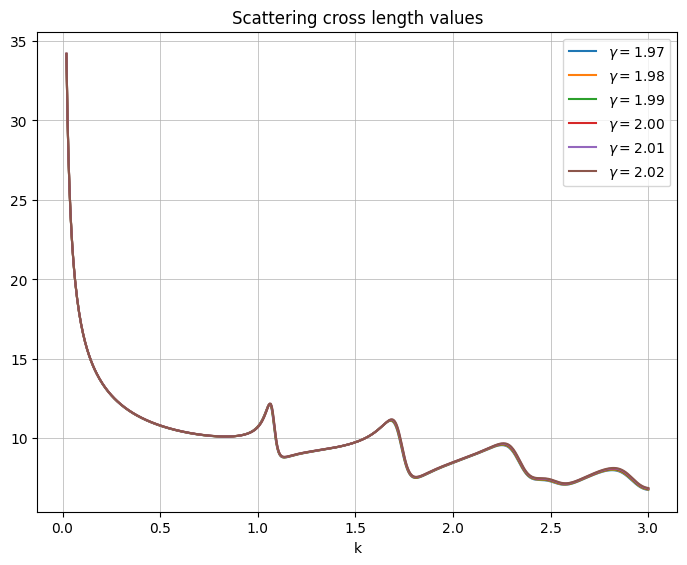

In [9]:
k_min = 0.02
k_max = 3.0
k = np.linspace(k_min, k_max, 596)

fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(k, l_array[0], ls='-', label=f"$\gamma = 1.97$")
axes.plot(k, l_array[1], ls='-', label=f"$\gamma = 1.98$")
axes.plot(k, l_array[2], ls='-', label=f"$\gamma = 1.99$")
axes.plot(k, l_array[3], ls='-', label=f"$\gamma = 2.00$")
axes.plot(k, l_array[4], ls='-', label=f"$\gamma = 2.01$")
axes.plot(k, l_array[5], ls='-', label=f"$\gamma = 2.02$")
axes.set_title(f'Scattering cross length values')
axes.set_xlabel(f'k')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

## Implementação da rede neural

### Definição dos inputs da rede

In [10]:
features = df.drop(columns=['gamma', 'R'])

features = features.to_numpy()

In [11]:
targets = df[['gamma', 'R']]

targets = targets.to_numpy()

In [12]:
print(features.shape)
print(targets.shape)

(55100, 603)
(55100, 2)


In [13]:
for _ in range(0):
    print('a')

### Definição da rede neural

A rede neural implementada é uma rede neural do tipo Multilayer Perceptron

In [14]:
def calculate_hidden_neurons(input_size, output_size):
    rule_1 = max(input_size, output_size)
    rule_2 = int(2/3 * input_size + output_size)
    rule_3 = min(2 * input_size - 1, input_size + input_size // 3)
    hidden_neurons = min(rule_1, rule_2, rule_3)
    return hidden_neurons

class GeneralizedMLP(nn.Module):
    def __init__(self, input_size, output_size, num_hidden_layers):
        super(GeneralizedMLP, self).__init__()
        hidden_neurons = calculate_hidden_neurons(input_size, output_size)
        
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_neurons))
        
        for _ in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_neurons, hidden_neurons))
        
        self.output_layer = nn.Linear(hidden_neurons, output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.sigmoid(layer(x))
        
        x = self.output_layer(x)
        return x

Função para treinamento do modelo

In [15]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

Função para avaliar o modelo

In [16]:
def evaluate_model(model, criterion, test_loader):
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(test_loader)}')

    return outputs

### Variáveis para o modelo, separação dos dados de teste e treino e etc

In [17]:
train, test_data = train_test_split(features, test_size = 0.2, random_state = 2)
real_train_data, validation_data = train_test_split(train, test_size = 0.3, random_state = 2)

train_target, test_target = train_test_split(targets, test_size = 0.2, random_state = 2)
real_train_target, validation_target = train_test_split(train_target, test_size = 0.3, random_state = 2)

input_size = 603
output_size = 2
batch_size = 32
num_epochs = 150
learning_rate = 0.0001

data_train = torch.tensor(real_train_data, dtype=torch.float32)
target_train = torch.tensor(real_train_target, dtype=torch.float32)

data_val = torch.tensor(validation_data, dtype=torch.float32)
target_val = torch.tensor(validation_target, dtype=torch.float32)

data_test = torch.tensor(test_data, dtype=torch.float32)
target_test = torch.tensor(test_target, dtype=torch.float32)

print("Input Shapes:")
print(data_train.shape, data_val.shape, data_test.shape)
print("Target Shapes:")
print(target_train.shape, target_val.shape, target_test.shape)

Input Shapes:
torch.Size([30856, 603]) torch.Size([13224, 603]) torch.Size([11020, 603])
Target Shapes:
torch.Size([30856, 2]) torch.Size([13224, 2]) torch.Size([11020, 2])


In [18]:
# Data Loaders
train_dataset = torch.utils.data.TensorDataset(data_train, target_train)
val_dataset = torch.utils.data.TensorDataset(data_val, target_val)
test_dataset = torch.utils.data.TensorDataset(data_test, target_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Primeira rodada de treinamento

In [19]:
model = GeneralizedMLP(input_size, output_size, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
evaluate_model(model, criterion, test_loader)

torch.save(model.state_dict(), 'mlp_weights.pth')

Epoch 1/150, Training Loss: 0.07947023854931151, Validation Loss: 0.032393880630505904
Epoch 2/150, Training Loss: 0.02950938876158524, Validation Loss: 0.0247076492405672
Epoch 3/150, Training Loss: 0.02449022693477494, Validation Loss: 0.021085708197386224
Epoch 4/150, Training Loss: 0.021896084521564177, Validation Loss: 0.019200427838992597
Epoch 5/150, Training Loss: 0.02008385704975054, Validation Loss: 0.018733865896392848
Epoch 6/150, Training Loss: 0.018408107626314608, Validation Loss: 0.016156608743845047
Epoch 7/150, Training Loss: 0.017399466769538165, Validation Loss: 0.01601456520755006
Epoch 8/150, Training Loss: 0.016504913201999555, Validation Loss: 0.015357119990692695
Epoch 9/150, Training Loss: 0.015617886158140675, Validation Loss: 0.01480903100910718
Epoch 10/150, Training Loss: 0.014767588614703306, Validation Loss: 0.01638840056774724
Epoch 11/150, Training Loss: 0.014259888614296256, Validation Loss: 0.013199674666314814
Epoch 12/150, Training Loss: 0.01387137

### Segunda rodada de treinamento

In [20]:
saved_state_dict = torch.load('mlp_weights.pth')

# Initialize the new model
extended_model = GeneralizedMLP(input_size, output_size, 2)

# Copy the weights of the hidden_layer to hidden_layer1

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

Epoch 1/150, Training Loss: 0.07975520916509929, Validation Loss: 0.015295596508160774
Epoch 2/150, Training Loss: 0.013231916316312018, Validation Loss: 0.010414078778526544
Epoch 3/150, Training Loss: 0.010437975158080112, Validation Loss: 0.011444682512963236
Epoch 4/150, Training Loss: 0.008967252102333068, Validation Loss: 0.007639129255259418
Epoch 5/150, Training Loss: 0.007974607115575242, Validation Loss: 0.006725875097118849
Epoch 6/150, Training Loss: 0.007396345396364503, Validation Loss: 0.006303633135169236
Epoch 7/150, Training Loss: 0.006877417078270659, Validation Loss: 0.0059313602559380955
Epoch 8/150, Training Loss: 0.006465680945521086, Validation Loss: 0.006532018142921067
Epoch 9/150, Training Loss: 0.00615184282910542, Validation Loss: 0.006176064368635461
Epoch 10/150, Training Loss: 0.0058352502943571525, Validation Loss: 0.005659874846890528
Epoch 11/150, Training Loss: 0.005585125948807919, Validation Loss: 0.005895744951398017
Epoch 12/150, Training Loss: 0

### Terceira rodada de treinamento

In [21]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = GeneralizedMLP(input_size, output_size, 3)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 2):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})

criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')


Epoch 1/150, Training Loss: 0.06929626075021314, Validation Loss: 0.004885990910062224
Epoch 2/150, Training Loss: 0.0029905645890339937, Validation Loss: 0.0021739355913405014
Epoch 3/150, Training Loss: 0.002054268611598654, Validation Loss: 0.0017331582958054175
Epoch 4/150, Training Loss: 0.0016487100314520242, Validation Loss: 0.0024303573238970443
Epoch 5/150, Training Loss: 0.001357369220796297, Validation Loss: 0.0010224614675302432
Epoch 6/150, Training Loss: 0.0011539190759251397, Validation Loss: 0.0008239887236431353
Epoch 7/150, Training Loss: 0.001091128460857221, Validation Loss: 0.0007610135565296486
Epoch 8/150, Training Loss: 0.0009959223816518724, Validation Loss: 0.0008892687214213673
Epoch 9/150, Training Loss: 0.0009033605174060158, Validation Loss: 0.0008286911083001796
Epoch 10/150, Training Loss: 0.0008927632734713921, Validation Loss: 0.0006410542422872383
Epoch 11/150, Training Loss: 0.0008190392590519354, Validation Loss: 0.0026067636166429283
Epoch 12/150, 

#### Quarta rodada de treinamento

In [22]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = GeneralizedMLP(input_size, output_size, 4)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 3):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

Epoch 1/150, Training Loss: 0.0739940550570965, Validation Loss: 0.0017155401910889155
Epoch 2/150, Training Loss: 0.001350866235796256, Validation Loss: 0.0009349779822936187
Epoch 3/150, Training Loss: 0.0010069403125738021, Validation Loss: 0.0008766332173473675
Epoch 4/150, Training Loss: 0.0008658383258466411, Validation Loss: 0.0013623653761598233
Epoch 5/150, Training Loss: 0.0007698745543147446, Validation Loss: 0.0005004005551977637
Epoch 6/150, Training Loss: 0.0007287102785513982, Validation Loss: 0.0005297456900119571
Epoch 7/150, Training Loss: 0.0006950657140904522, Validation Loss: 0.000719564509069646
Epoch 8/150, Training Loss: 0.0006702793498343783, Validation Loss: 0.0005170188599281859
Epoch 9/150, Training Loss: 0.0006432209724115227, Validation Loss: 0.0005229278090792362
Epoch 10/150, Training Loss: 0.0006254390288410356, Validation Loss: 0.00040836890919941334
Epoch 11/150, Training Loss: 0.0006097287657188729, Validation Loss: 0.00039166395488765386
Epoch 12/15

### Prediction to R = 2 and gamma = 2

In [23]:
# evaluate_model(extended_model, criterion, test_loader)
test_target.shape

(11020, 2)

In [24]:
row_gamma_R_2

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k587,l_k588,l_k589,l_k590,l_k591,l_k592,l_k593,l_k594,l_k595,l_k596
35719,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.976471,2.0,34.160977,...,6.956875,6.919069,6.885087,6.855019,6.828886,6.806644,6.788192,6.773382,6.762030,6.753920
35909,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.986505,2.0,34.171447,...,6.987403,6.948690,6.913837,6.882948,6.856052,6.833113,6.814034,6.798671,6.786840,6.778324
36099,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,1.996540,2.0,34.181816,...,7.017881,6.978250,6.942513,6.910788,6.883115,6.859463,6.839742,6.823812,6.811488,6.802554
36289,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,2.006574,2.0,34.192086,...,7.048311,7.007750,6.971118,6.938543,6.910077,6.885697,6.865320,6.848808,6.835977,6.826611
36479,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,2.016609,2.0,34.202258,...,7.078696,7.037195,6.999654,6.966216,6.936942,6.911820,6.890772,6.873662,6.860311,6.850500
36669,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,2.026644,2.0,34.212333,...,7.109038,7.066588,7.028126,6.993810,6.963714,6.937834,6.916099,6.898378,6.884491,6.874222


In [25]:
row_gamma2_R_2 = row_gamma_R_2[(row_gamma_R_2['gamma'] > 2.0) & (row_gamma_R_2['gamma'] < 2.01)]

In [26]:
row_gamma2_R_2

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k587,l_k588,l_k589,l_k590,l_k591,l_k592,l_k593,l_k594,l_k595,l_k596
36289,1.0,1.0,0.02,3.0,0.005,-20.0,20.0,2.006574,2.0,34.192086,...,7.048311,7.00775,6.971118,6.938543,6.910077,6.885697,6.86532,6.848808,6.835977,6.826611


In [27]:
inputs_row_gamma2_R_2 = row_gamma2_R_2.drop(columns=['gamma', 'R'])
inputs_row_gamma2_R_2 = inputs_row_gamma2_R_2.to_numpy()

In [28]:
inputs_row_gamma2_R_2.shape

(1, 603)

In [29]:
test_r2_gamma2 = np.array([[2.0], [2.0]]).transpose()

In [30]:
test_r2_gamma2.shape

(1, 2)

In [31]:
inputs_tensor_row_gamma2_R_2 = torch.tensor(inputs_row_gamma2_R_2, dtype=torch.float32)
target_test_r2_gamma2 = torch.tensor(test_r2_gamma2, dtype=torch.float32)

In [34]:
test_r2_gamma2_dataset = torch.utils.data.TensorDataset(inputs_tensor_row_gamma2_R_2, target_test_r2_gamma2)
test_r2_gamma2_loader = torch.utils.data.DataLoader(test_r2_gamma2_dataset, batch_size=1, shuffle=False)

In [35]:
outputs = evaluate_model(extended_model, criterion, test_r2_gamma2_loader)
outputs

Test Loss: 0.00016762154700700194


tensor([[2.0078, 1.9835]])

In [36]:
predicted = outputs.squeeze().tolist()
predicted_gamma_R = np.array(predicted)

In [39]:
print('Considerando os dados para R = 2.0 e gamma = 2.0')
print('Os valores obtidos foram: ')
print('gamma: ', predicted_gamma_R[0])
print('R: ', predicted_gamma_R[1])
print('Erro quadrático médio: ', 0.00016762154700700194)

Considerando os dados para R = 2.0 e gamma = 2.0
Os valores obtidos foram: 
gamma:  2.0078394412994385
R:  1.9834535121917725
Erro quadrático médio:  0.00016762154700700194
